In [1]:
!pip install transformers
!pip install sentence-transformers

     |████████████████████████████████| 2.9 MB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 46.2 MB/s 
     |████████████████████████████████| 56 kB 4.9 MB/s 
     |████████████████████████████████| 895 kB 60.5 MB/s 
     |████████████████████████████████| 636 kB 50.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 78 kB 3.3 MB/s 
     |████████████████████████████████| 1.2 MB 11.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=d9ae6bc24304c6e6278d0e656caa45622d853427be3976a137683b79dbc652a7
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers


In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import transformers
import torch
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer
# Remember to mount drive!

import plotly
import numpy as np
import plotly.graph_objs as go
from sklearn.decomposition import PCA
import re

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
ROOT_DIR =  "drive/MyDrive/DecorAssist/"
DATASET_DIR = ROOT_DIR + "IKEA/text_data/"

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]') # ??
STOPWORDS = set(stopwords.words('english'))

In [3]:
def read_pickle(fn):
	'''
	# Functionality
		Save the data into pickle format
	# Arguments
		fn: the pickle file name
	# Returns
		obj: the desired data object
	'''
	with open(fn, "rb") as f:
		return pickle.load(f)
	

def text_prepare(text):
	text = text.lower() # lowercase text
	text = re.sub(REPLACE_BY_SPACE_RE, " ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
	text = re.sub(BAD_SYMBOLS_RE, "", text)      # delete symbols which are in BAD_SYMBOLS_RE from text
	text = " ".join([word for word in text.split(" ") if word not in STOPWORDS]) # delete stopwords from text
	text = re.sub('[^a-zA-Z]+', ' ', text)
	text = re.sub(' +', ' ', text)
	return text.strip()
	
def get_all_unique_words(descriptions):
	words = []
	for text in descriptions:
		text = text_prepare(text)
		words += text.split() 
	return list(set([word for word in words]))

In [4]:
# {room image url -> string of room category}; e.g.: 'ikea-town-and-country__1364308377063-s4.jpg': 'Living Room'
room_categories = read_pickle(DATASET_DIR + "categories_dict.p")
# {item image ID -> string of item category}; e.g.: '291.292.29': 'Footstool',
item_categories = read_pickle(DATASET_DIR + "categories_images_dict.p")
# {item image id -> dict of descriptions}; e.g. '202.049.06': {'color': 'Grey,black','desc': 'View more product information Concealed press studs keep the quilt in place','img': 'images/objects/202.049.06.jpg','name': 'GURLI','size': '120x180 cm','type': 'Throw'},
item_property = read_pickle(DATASET_DIR + "products_dict.p")
# {item image url -> {description, name}}; e.g: '/static/images/902.592.50.jpg': {'desc': 'The high pile dampens sound and provides a soft surface to walk on.','name': 'GSER'},
item_to_description = read_pickle(DATASET_DIR + "img_to_desc.p")
# {item image url -> list of corresponding room image url}; e.g.: 'images/001.509.85.jpg': ['images/room_scenes/ikea-wake-up-and-grow__1364335362013-s4.jpg','images/room_scenes/ikea-wake-up-and-grow-1364335370196.jpg'],
item_to_rooms_map = read_pickle(DATASET_DIR + "item_to_room.p")
# {room image url -> list of items}; e.g.: 'ikea-work-from-home-in-perfect-harmony__1364319311386-s4.jpg': ['desk','chair']
room_to_item_categories = read_pickle(DATASET_DIR + "room_to_items.p")

# Some simple preprossing
item_to_info = {key : value["type"] + " " +
                             value["desc"] + " " +
                             value["name"]
                       for key, value in item_property.items()}


unique_infos = list(set(item_to_info.values()))

In [5]:
item_to_info

{'500.210.76': 'Easel View more product information Your child can use it for different purposes. The easel has a whiteboard on one side and a blackboard on the other. MLA',
 '802.538.09': 'Reversible bed View more product information Turned upside down the bed quickly converts from a low to a high bed. KURA',
 '802.962.48': 'Quilt cover and pillowcase Made from 100% cotton, a natural material thats soft against your childs skin and gets softer with every wash. STICKAT',
 '502.962.97': 'Bed pocket Clever storage solution that you can hang on our childrens beds. STICKAT',
 '203.086.97': 'Frame A playful and sturdy storage series for storing and organising toys, sitting, playing and relaxing. TROFAST',
 '302.980.23': 'Storage box Fits in TROFAST frames. TROFAST',
 '501.158.62': 'Storage box Fits in TROFAST frames. TROFAST',
 '600.940.72': 'Storage box View more product information Fits in TROFAST frames. TROFAST',
 '201.932.67': 'Watercolour box Paint in vivid colours that blends smoothl

### EDA
1. How many labels are there for items / objects? Distribution
2. How many labels are there for rooms? Distribution
3. Most popular words for item descriptions
4. tsne and similarity function for word vectors (take two descriptions, compute score) for (item, item), (room, room), (item, room)
5. Bert encoding tsne and similarity function (take two descriptions, compute score) for (item, item), (room, room), (item, room)


## Exploratory Data Analysis

In [6]:
list(item_to_info.values())[:5]

['Easel View more product information Your child can use it for different purposes. The easel has a whiteboard on one side and a blackboard on the other. MLA',
 'Reversible bed View more product information Turned upside down the bed quickly converts from a low to a high bed. KURA',
 'Quilt cover and pillowcase Made from 100% cotton, a natural material thats soft against your childs skin and gets softer with every wash. STICKAT',
 'Bed pocket Clever storage solution that you can hang on our childrens beds. STICKAT',
 'Frame A playful and sturdy storage series for storing and organising toys, sitting, playing and relaxing. TROFAST']

In [7]:
all_words = get_all_unique_words(unique_infos)

In [8]:
print("Total number of rooms in the dataset: ", len(room_categories.keys()))
print("Total number of items in the dataset: ", len(item_categories.keys()))
print("Number of unique room categories in the dataset: ", len(set(room_categories.values())))
print("Number of unique item categories in the dataset: ", len(set(item_categories.values())))
print("Number of unique item descriptions in the dataset: ", len(unique_infos))
print("Number of unique words in all descriptions: ", len(all_words))

Total number of rooms in the dataset:  262
Total number of items in the dataset:  2191
Number of unique room categories in the dataset:  9
Number of unique item categories in the dataset:  677
Number of unique item descriptions in the dataset:  1750
Number of unique words in all descriptions:  3092


In [9]:
all_words[:20]

['sovdags',
 'bulbs',
 'efficiently',
 'writing',
 'sight',
 'grow',
 'inner',
 'veneered',
 'vejmon',
 'concealed',
 'drive',
 'frames',
 'across',
 'duvet',
 'extension',
 'runner',
 'hllestad',
 'likely',
 'foto',
 'maintenancefree']

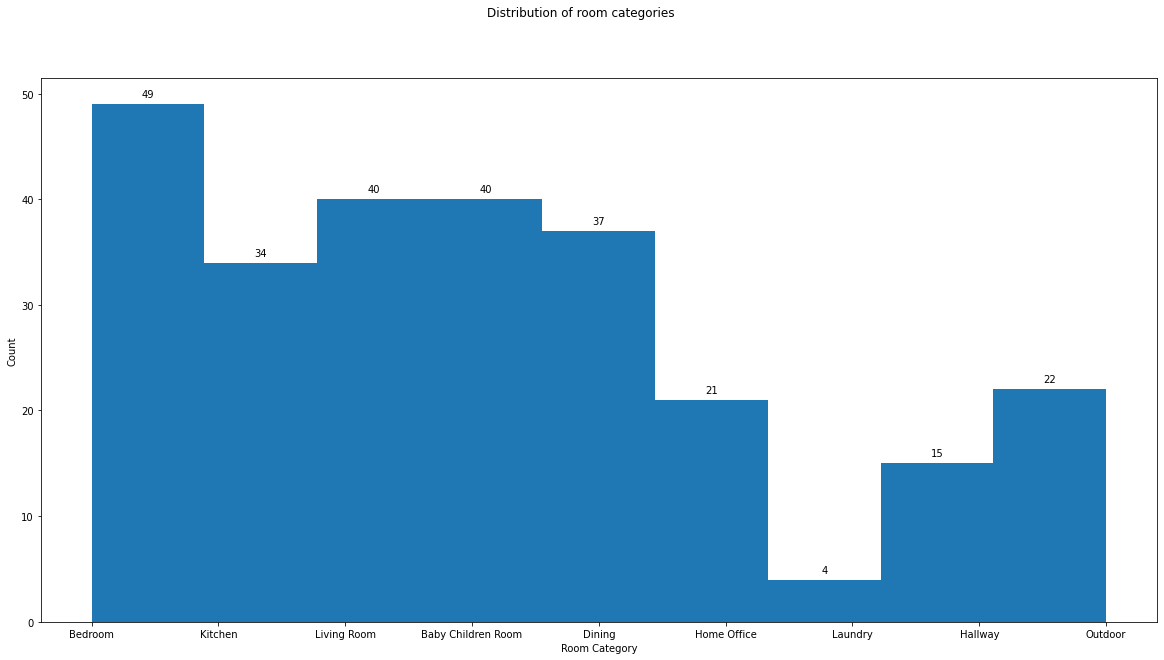

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.hist(list(room_categories.values()), align="mid", bins=len(set(room_categories.values())))

fig.suptitle('Distribution of room categories', fontsize=12)
ax.set_xlabel('Room Category', fontsize=10)
ax.set_ylabel('Count', fontsize='medium')

for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x() + rect.get_width() / 2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 

### Bert Encoding Step

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
simple_model = BertModel.from_pretrained('bert-base-uncased')
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')


def simple_bert_embedder(sentences):
  inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True)
  outputs = simple_model(**inputs)
  return torch.mean(outputs.last_hidden_state, axis=1).detach().numpy()

def sentence_bert_embedder(sentences):
  return sbert_model.encode(sentences).detach().numpy()

def cosine(u, v):
    # compute the similarity between two embeddings
    # u and v are matrices!
    return np.einsum('ij,ij->i', u, v) / ((np.linalg.norm(u, axis=1) * np.linalg.norm(v, axis=1)))

def topn(candidate_desc, embedding_store):
  pass



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
# sentbert_embeddings = sentence_bert_embedder(sbert_model, list(item_to_description.values())[:10])

In [15]:
def tsne_plot(all_words, embed_func=simple_bert_embedder, number_of_words=200):
    
  simple_embeddings = embed_func(all_words[:number_of_words])
  word_to_emb_dict = {}
  for i in range(len(all_words[:number_of_words])):
    word_to_emb_dict[all_words[i].lower()] = simple_embeddings[i]
    
  # https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
  # In word_to_emb_dict, we map a word to corresponding numpy embedding vector of shape (n, )
  labels = []
  tokens = []

  for word, emb in word_to_emb_dict.items():
    tokens.append(emb)
    labels.append(word)
  
  
  tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500, random_state=23)
  new_values = tsne_model.fit_transform(tokens)

  x = []
  y = []
  for value in new_values:
      x.append(value[0])
      y.append(value[1])
      
  plt.figure(figsize=(20, 20)) 
  for i in range(len(x)):
      plt.scatter(x[i],y[i])
      plt.annotate(labels[i],
                    xy=(x[i], y[i]),
                    xytext=(5, 2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
  plt.show()

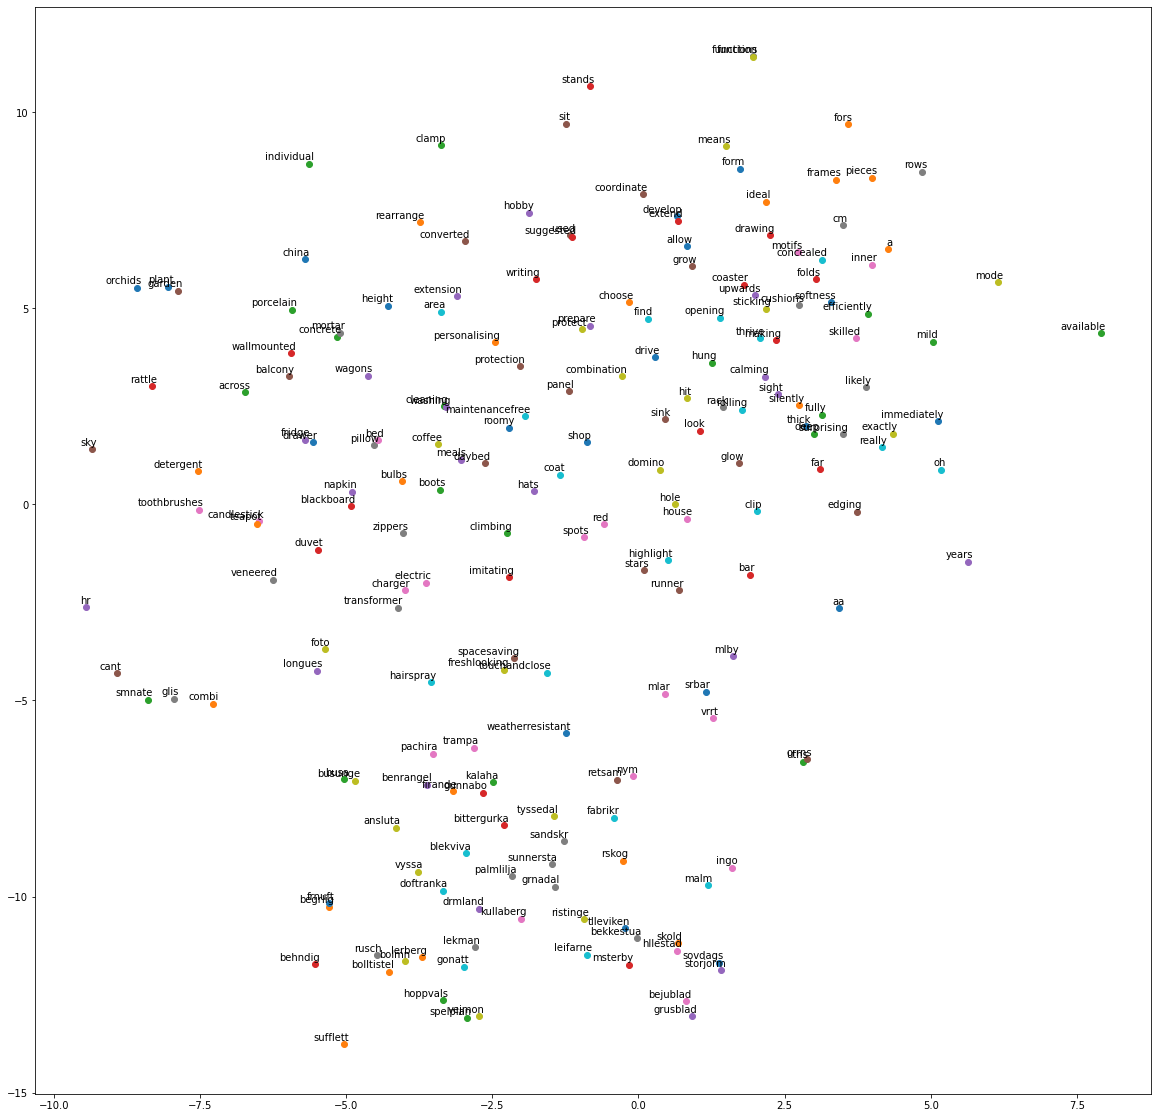

In [16]:
tsne_plot(all_words)